## **Data Loader**

Total Images Imported 31107


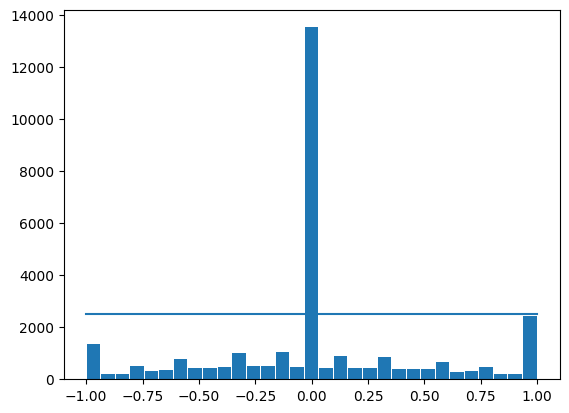

Removed Images: 11027
Remaining Images: 20080


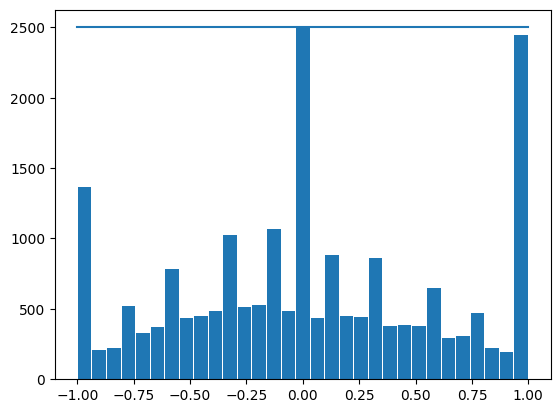

20080
Total Training Images:  16064
Total Validation Images:  4016


In [51]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
from PIL import Image
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Convolution2D,Flatten,Dense
from keras.optimizers import Adam

def getName(filePath):
    a = filePath.split('\\')[-1]
    return 'Hill_dataset/IMG/' + a


def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names=columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    data['Center'] = data['Center'].apply(getName)
    data['Left'] = data['Left'].apply(getName)
    data['Right'] = data['Right'].apply(getName)

    print('Total Images Imported', data.shape[0])
    return data

def balanceData(data,display=True):
    nBin = 31
    # samplesPerBin = 2500
    samplesPerBin = 2500
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    # print(type(removeindexList))
    # print(removeindexList)
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    # print(type(data))

    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    return data

def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(f'{path}/IMG/{indexed_data[0]}')
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

# Function for image augmentation
def augmentImage(imgPath,val):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        val[0] = -val[0]
    return img, val



# Functions for preprocessing
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255

    # im = Image.fromarray(img,'RGB')
    # im.show()
    # time.sleep(1)
    return img

    # Functions for batch generation
def batchGen(imagesPath, val, batchSize, trainFlag):
    while True:
        imgBatch = []
        driving_log = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, output = augmentImage(imagesPath[index][0], val[:][index])
            else:
                img = mpimg.imread(imagesPath[index][0])
                output = val[:][index]
            img = preProcess(img)
            imgBatch.append(img)
            driving_log.append(output)
        yield (np.asarray(imgBatch), np.asarray(driving_log))


path = 'Hill_dataset'
data = importDataInfo(path)
data

data = balanceData(data, display=True)
# data = pd.DataFrame(data)
print(len(data))
# print(data)

numpydata = data.values
# print(numpydata[:,:])

# take all driving log
# xTrain, xVal, yTrain, yVal = train_test_split(numpydata[:,:1], numpydata[:,3:6], test_size=0.2,random_state=10)

# take only image and steering
xTrain, xVal, yTrain, yVal = train_test_split(numpydata[:,:1], numpydata[:,3:4], test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

yTrain = np.asarray(yTrain).astype(np.float32)
yVal = np.asarray(yVal).astype(np.float32)



In [52]:
# xTrain = np.squeeze(xTrain)
# xVal = np.squeeze(xVal)
# yTrain = np.squeeze(yTrain)
# yVal = np.squeeze(yVal)
# xTrain


array(['Hill_dataset/IMG/center_2023_02_10_04_03_24_344.jpg',
       'Hill_dataset/IMG/center_2023_02_10_03_45_19_707.jpg',
       'Hill_dataset/IMG/center_2023_02_10_04_04_55_703.jpg', ...,
       'Hill_dataset/IMG/center_2023_02_10_04_04_09_141.jpg',
       'Hill_dataset/IMG/center_2023_02_10_03_27_44_558.jpg',
       'Hill_dataset/IMG/center_2023_02_10_04_04_02_542.jpg'],
      dtype=object)

## **Model Training : NVIDIA MODEL**

In [53]:
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.models import Sequential

def get_model():
    
    model = Sequential()

    # # The inputs are 66x200x3(RGB) images with `channels_last` and the batch size is 24.
    # For CNNs that are trained on images, for example, say your dataset is RGB (3-channel) images that are 256x256
    # pixels. A single image can be represented by a 3 x 256 x 256 matrix.If you set your batch size to be 10, that
    # means you’re concatenating 10 images together into a 10 x 3 x 256 x 256 matrix.

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    model.compile(Adam(lr=0.0001), loss='mse')
    return model

model = get_model()

model.compile(Adam(lr=0.0001), loss='mse')
history = model.fit(batchGen(xTrain, yTrain, 50, 1),
                                  steps_per_epoch=200,
                                  epochs=5,
                                  validation_data=batchGen(xVal, yVal, 100, 0),
                                  validation_steps=200)

model.save('NVIDIA_MODEL.h5')
print('Model Saved')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

d:\AppData\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
105/200 [==============>...............] - ETA: 35s - loss: 0.2855

KeyboardInterrupt: 

## **Model Testing : UDACITY Simulator**

In [1]:
print('Setting UP')
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import socketio
import eventlet
import numpy as np
from flask import Flask
from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2

#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'

maxSpeed = 10


def Process(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img


@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])

    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = Process(image)
    image = np.array([image])

    drivingLog = (model.predict(image))
    steering = drivingLog[0][0]
    throttle = 1.0 - speed / maxSpeed
    print(steering)
    # print(f'{steering}, {throttle}, {speed}')
    sendControl(steering, throttle)


@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    sendControl(0, 0)


def sendControl(steering, throttle):
    sio.emit('steer', data={
        'steering_angle': steering.__str__(),
        'throttle': throttle.__str__()
    })


if __name__ == '__main__':
    model = load_model('NVIDIA_MODEL.h5')
    app = socketio.Middleware(sio, app)
    ### LISTEN TO PORT 4567
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)



Setting UP


(11304) wsgi starting up on http://0.0.0.0:4567
(11304) accepted ('127.0.0.1', 9907)


Connected
1/1 [==============================] - 0s 315ms/step
0.13303399
1/1 [==============================] - 0s 50ms/step
0.13241307
1/1 [==============================] - 0s 51ms/step
0.13241307
1/1 [==============================] - 0s 63ms/step
0.13319644
1/1 [==============================] - 0s 58ms/step
0.12691283
1/1 [==============================] - 0s 150ms/step
0.11545603
1/1 [==============================] - 0s 47ms/step
0.11065377
1/1 [==============================] - 0s 78ms/step
0.11377198
1/1 [==============================] - 0s 46ms/step
0.116691634
1/1 [==============================] - 0s 60ms/step
0.11120715
1/1 [==============================] - 0s 58ms/step
0.085130334
1/1 [==============================] - 0s 49ms/step
0.07605382
1/1 [==============================] - 0s 54ms/step
0.08822476
1/1 [==============================] - 0s 91ms/step
0.06172589
1/1 [==============================] - 0s 61ms/step
0.035273995
1/1 [==============================] - 0

(11304) accepted ('127.0.0.1', 9908)


Connected
1/1 [==============================] - 0s 55ms/step
0.02343948
1/1 [==============================] - 0s 49ms/step
0.02343948
1/1 [==============================] - 0s 34ms/step
0.023418063
1/1 [==============================] - 0s 90ms/step
0.06465524
1/1 [==============================] - 0s 32ms/step
0.07314045
1/1 [==============================] - 0s 49ms/step
0.09304899
1/1 [==============================] - 0s 31ms/step
0.057230975
1/1 [==============================] - 0s 49ms/step
0.059229556
1/1 [==============================] - 0s 26ms/step
0.08452613
1/1 [==============================] - 0s 42ms/step
0.06828407
1/1 [==============================] - 0s 53ms/step
0.05653676
1/1 [==============================] - 0s 52ms/step
0.060691595
1/1 [==============================] - 0s 51ms/step
0.08265085
1/1 [==============================] - 0s 35ms/step
0.0712736
1/1 [==============================] - 0s 42ms/step
0.06256534
1/1 [==============================] - 0s 

(11304) accepted ('127.0.0.1', 9912)


1/1 [==============================] - 0s 43ms/step
0.13812523
1/1 [==============================] - 0s 63ms/step
0.13812523
1/1 [==============================] - 0s 47ms/step
0.13812523
1/1 [==============================] - 0s 59ms/step
0.1333642
1/1 [==============================] - 0s 55ms/step
0.13215713
1/1 [==============================] - 0s 69ms/step
0.1281489
1/1 [==============================] - 0s 51ms/step
0.12135773
1/1 [==============================] - 0s 49ms/step
0.11649736
1/1 [==============================] - 0s 49ms/step
0.11507599
1/1 [==============================] - 0s 59ms/step
0.11175799
1/1 [==============================] - 0s 62ms/step
0.1170139
1/1 [==============================] - 0s 56ms/step
0.115985036
1/1 [==============================] - 0s 69ms/step
0.119976714
1/1 [==============================] - 0s 50ms/step
0.11238636
1/1 [==============================] - 0s 50ms/step
0.11714752
1/1 [==============================] - 0s 57ms/step
0.10

127.0.0.1 - - [10/Feb/2023 12:21:33] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 20.877838
127.0.0.1 - - [10/Feb/2023 12:21:33] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 51.694656
127.0.0.1 - - [10/Feb/2023 12:21:33] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 40.507795
wsgi exiting
(11304) wsgi exited, is_accepting=True


## **New Model**

In [4]:
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, ELU
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf

def build_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(66, 200, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(1))

    model.compile(Adam(lr=0.0001), loss='mse')
    return model


model = build_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(batchGen(xTrain, yTrain, 100, 1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batchGen(xVal, yVal, 100, 0),
                    validation_steps=200,
                    callbacks=[early_stopping])

model.save('Our_MODEL_6.h5')
print('Model Saved')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')


NameError: name 'Adam' is not defined